# Factor Investing Exercise

Using several pre-selected factors and econmic factors, test out the key drivers of return for the EB level. A regression of EB returns on these factor returns shows which regression coefficients are statistically significant. Several regressions are tested and a view of correlations, cummulative returns and drawdown is also included. Finally, a matrix of single factor regression results is presented.

In [1]:
from datetime import datetime
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like #absolutely necessary else pandas_datareader fails
import pandas_datareader.data as dr

from pandas import DataFrame
from pandas.io.parsers import read_csv
from pandas.tseries.offsets import BMonthEnd
from statsmodels.formula.api import ols

# Read factor levels from CSV
factorPxFilename = 'input/factor2_prices.csv'
factorPxDf = read_csv(factorPxFilename, index_col='Date', parse_dates=True).dropna(how='all', axis=1)
factorPxDf.fillna(method='ffill', inplace=True)

startDt = min(factorPxDf.index)
endDt = max(factorPxDf.index)

# Get EB Monthly Returns
ebRetFilename = 'input/eb_ret.csv'
ebType = 'EB'
ebRetDf = read_csv(ebRetFilename, index_col='Date', parse_dates=True).dropna(how='all', axis=1)
ebRetDf.index = ebRetDf.index + BMonthEnd()
ebRetDf = ebRetDf/100

# Get economic factors from FRED
ecoFactors = {'DGS10': '10-Year Treasury Constant Maturity Rate',
        'CPIAUCSL': 'Consumer Price Index for All Urban Consumers: All Items',
        'INDPRO': 'Industrial Production Index',
        'GDPC1': 'Real Gross Domestic Product',
        'DEXUSEU': 'U.S. / Euro Foreign Exchange Rate',
        'UNRATE': 'Civilian Unemployment Rate',
        'PAYEMS': 'All Employees: Total nonfarm',
        'IC4WSA': '4-Week Moving Average of Initial Claims'}
fredDict = {}

for ecoFactor, des in ecoFactors.items():
    x = dr.DataReader(ecoFactor, data_source="fred", start=startDt, end=endDt)[ecoFactor]
    fredDict[ecoFactor] = x
    
fredDf = DataFrame(fredDict).applymap(lambda x: None if x=='.' else x).astype('float')
fredDf.fillna(method='ffill', inplace=True)
factorPxDf = factorPxDf.join(fredDf)

print("Factor levels: ", factorPxDf.columns)
print("EB returns:", ebRetDf.columns)

Factor levels:  Index(['MXWO Index', 'MXWO000V Index', 'MXWO000G Index', 'MXWOSC Index',
       'MXWOLC Index', 'MXEF Index', 'MOODCAAA Index', 'USYC2Y30 Index',
       'BXIIUL10 Index', 'MSBITPTR Index', 'VIX Index', 'MLT1US10 Index',
       'MOODCBAA Index', 'MOODCAAA Index.1', 'IBOXHY Index', 'CPIAUCSL',
       'DEXUSEU', 'DGS10', 'GDPC1', 'IC4WSA', 'INDPRO', 'PAYEMS', 'UNRATE'],
      dtype='object')
EB returns: Index(['EB'], dtype='object')


## Compute the factor returns and display correlations

In [2]:
# Resample & Compute Factor Monthly Returns
factorRetDfRaw = factorPxDf.fillna(method='ffill').pct_change()

# Callan Factors
factorRetDict = {'DevMktEcoGrow' : factorRetDfRaw['MXWO Index'],
                 'Value' : (factorPxDf['MXWO000V Index'] - factorPxDf['MXWO Index']).pct_change(),
                 'Size' : (factorPxDf['MXWOSC Index'] - factorPxDf['MXWO Index']).pct_change(),
                 'EM' : (factorPxDf['MXEF Index'] - factorPxDf['MXWO Index']).pct_change(),
                 'AAABAASpread' : (factorPxDf['MOODCBAA Index'] - factorPxDf['MOODCAAA Index']).pct_change(),
                 #'Inflation' : (factorPxDf['MLT1US10 Index'] - factorPxDf['MSBITPTR Index']).pct_change(),
                 'Inflation' : -factorRetDfRaw['MLT1US10 Index'] + factorRetDfRaw['MSBITPTR Index'],
                 'HY' : factorRetDfRaw['IBOXHY Index'],
                 'US10YTreasFut' : factorRetDfRaw['MLT1US10 Index'],
                 'Duration' : factorRetDfRaw['USYC2Y30 Index'],
                 'RealRates' : factorRetDfRaw['MSBITPTR Index'],
                 'Volatility' : factorRetDfRaw['VIX Index']}

factorRetDf = DataFrame.from_dict(factorRetDict, orient='index').T

idx = [x > datetime(2001,12,31) for x in factorRetDf.index]
factorRetDf = factorRetDf[idx]

# Examine factor correlation
factorRetDf.corr()

,AAABAASpread,DevMktEcoGrow,Duration,EM,HY,Inflation,RealRates,Size,US10YTreasFut,Value,Volatility
AAABAASpread,1.000000,-0.474045,-0.004271,-0.085407,-0.568517,-0.493921,-0.120656,-0.461502,0.259108,-0.398033,0.443873
DevMktEcoGrow,-0.474045,1.000000,-0.021719,0.157320,0.729423,0.486917,0.118241,0.997850,-0.256160,0.923280,-0.667844
Duration,-0.004271,-0.021719,1.000000,-0.012640,-0.058536,0.014231,0.006333,-0.009056,-0.004525,0.004573,0.001172
EM,-0.085407,0.157320,-0.012640,1.000000,0.016650,-0.065668,-0.135950,0.171696,-0.089009,0.282155,-0.137793
HY,-0.568517,0.729423,-0.058536,0.016650,1.000000,0.575611,0.283797,0.720763,-0.154540,0.638696,-0.533228
Inflation,-0.493921,0.486917,0.014231,-0.065668,0.575611,1.000000,0.414489,0.470202,-0.349350,0.362238,-0.339590
RealRates,-0.120656,0.118241,0.006333,-0.135950,0.283797,0.414489,1.000000,0.113454,0.707912,0.051528,-0.040486
Size,-0.461502,0.997850,-0.009056,0.171696,0.720763,0.470202,0.113454,1.000000,-0.248115,0.923940,-0.662455
US10YTreasFut,0.259108,-0.256160,-0.004525,-0.089009,-0.154540,-0.349350,0.707912,-0.248115,1.000000,-0.228083,0.221874
Value,-0.398033,0.923280,0.004573,0.282155,0.638696,0.362238,0.051528,0.923940,-0.228083,1.000000,-0.579909


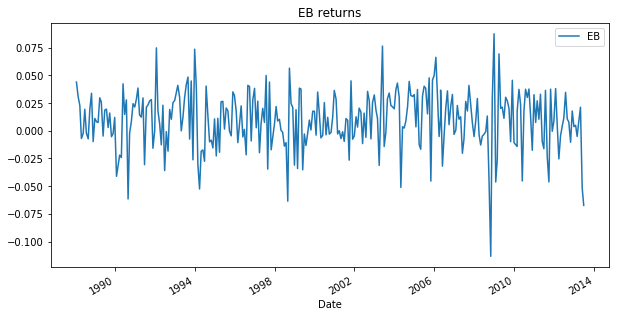

In [12]:
ebRetDf.plot(title="EB returns", figsize=(10,5))

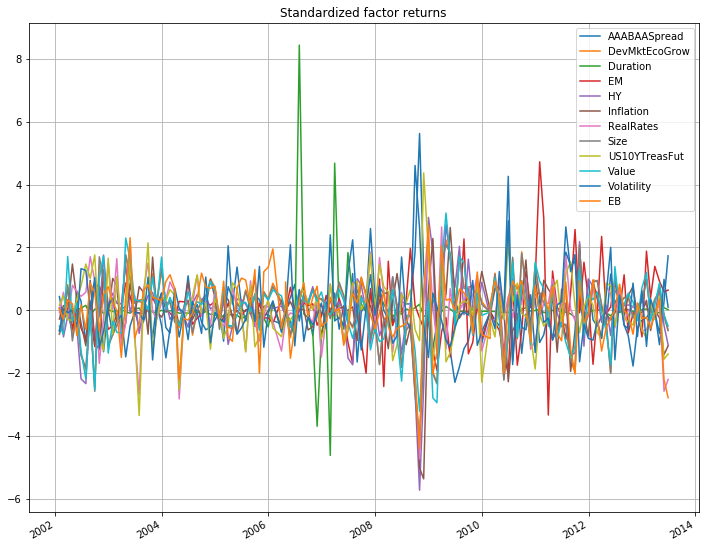

In [4]:
# Factors of interest
factors = [x for x in factorRetDf.keys()]

# Put factor returns and EB returns in one dataframe
df = factorRetDf.join(ebRetDf).dropna(axis=0)

# Create a standardized dataframe
zscore = lambda x: (x - x.mean()) / x.std()
zDf = df.apply(zscore, axis=0)

zDf[factors+[ebType]].plot(figsize=(12,10), grid=True, title="Standardized factor returns")

## Regress EB on several factors

                            OLS Regression Results                            
Dep. Variable:                     EB   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     35.41
Date:                Wed, 25 Jul 2018   Prob (F-statistic):           7.55e-23
Time:                        23:24:55   Log-Likelihood:                 355.87
No. Observations:                 138   AIC:                            -699.7
Df Residuals:                     132   BIC:                            -682.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0057      0.002      3.292      0.0

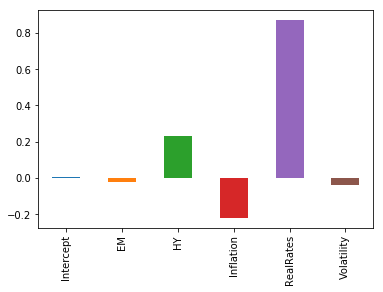

In [5]:
import statsmodels.formula.api
    
model1 = ols(formula='EB ~ EM + HY + Inflation + RealRates + Volatility', data=df).fit()
print(model1.summary())
model1.params.plot(kind="bar")

The regression is significant since the F-statistic is greater than 4. However, only the HY, RealRates and Volatility factors are statistically significant (|t-statistic| > 3).


## Show how well the fitted model follows the EB returns and cummulative value

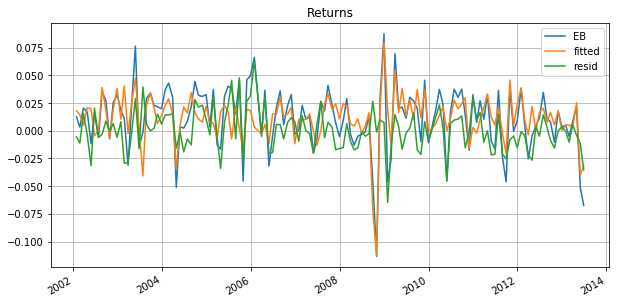

<Figure size 432x288 with 0 Axes>

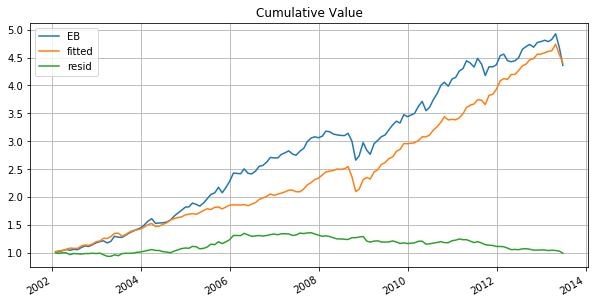

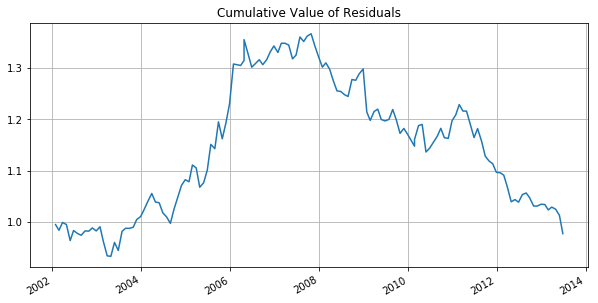

In [6]:
import matplotlib.pyplot as plt
fitDf = DataFrame.from_dict({'fitted': model1.fittedvalues, ebType: df[ebType], 'resid': model1.resid}, orient='index').T
fitDf.plot(figsize=(10,5), grid=True, title='Returns')
plt.figure()

cvDf = (fitDf + 1.0).cumprod(axis=0)
cvDf.plot(figsize=(10,5), grid=True, title='Cumulative Value')
plt.figure()

(model1.resid + 1.0).cumprod().plot(figsize=(10,5), grid=True, title='Cumulative Value of Residuals')

## Regress on another set of factors, the significant ones above plus two others.

                            OLS Regression Results                            
Dep. Variable:                     EB   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     50.85
Date:                Wed, 25 Jul 2018   Prob (F-statistic):           3.76e-29
Time:                        23:24:57   Log-Likelihood:                 371.25
No. Observations:                 138   AIC:                            -730.5
Df Residuals:                     132   BIC:                            -712.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0056      0.002      3.692

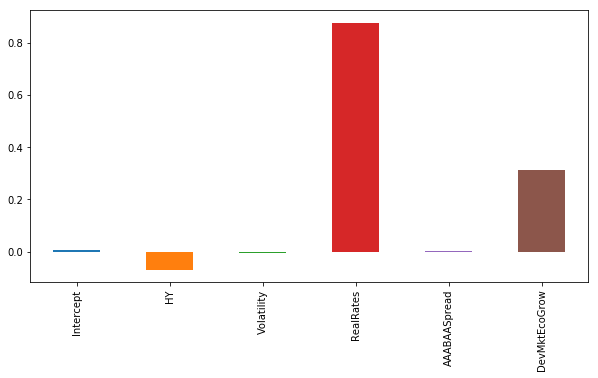

In [7]:
# Run Regression
model2 = ols(formula='EB ~ HY + Volatility + RealRates + AAABAASpread + DevMktEcoGrow', data=df).fit()
print(model2.summary())
model2.params.plot(figsize=(10,5), kind='bar')

The regression is significant and only the RealRates and DevMktEcoGrow factors seem to be drivers for EB.

## Show the rolling Draw Down

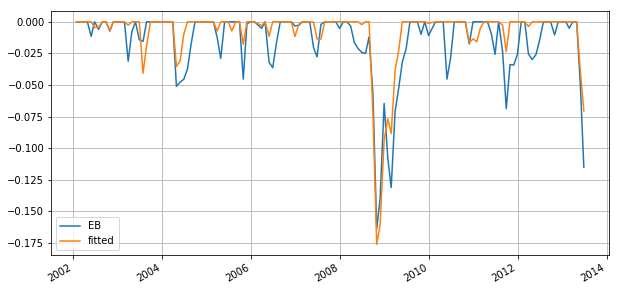

In [8]:
cvDD = (cvDf / pd.core.window.expanding(cvDf).max())-1.0
cvDD.drop('resid', axis=1).plot(figsize=(10,5), grid=True)
#(-1*(cvDf[['EB','fitted']].cummax()-cvDf[['EB','fitted']])).plot(figsize=(10,5), grid=True)

## Display the individually regressed statistics for each factor

In [9]:
singleFactors = ['HY', 'Volatility','AAABAASpread','RealRates','DevMktEcoGrow','US10YTreasFut','Inflation']

regDict = {}
for factor in singleFactors:
    regDict[factor] = {}
    smodel = ols(formula="EB ~ {}".format(factor), data = zDf).fit()
    
    regDict[factor]['coef'] = smodel.params[factor]
    regDict[factor]['t-stat'] = smodel.tvalues[factor]
    regDict[factor]['r2'] = smodel.rsquared
    regDict[factor]['p-value'] = smodel.pvalues[factor]

idx = ['coef','t-stat','r2','p-value']    
regDf = DataFrame.from_dict(regDict, orient='index')
regDf[idx]

,coef,t-stat,r2,p-value
AAABAASpread,-0.293638,-3.582296,0.086223,4.732267e-04
DevMktEcoGrow,0.567200,8.031555,0.321716,4.076018e-13
HY,0.497876,6.694954,0.247881,5.195941e-10
Inflation,0.374266,4.706727,0.140075,6.122985e-06
RealRates,0.640368,9.722974,0.410071,2.740987e-17
US10YTreasFut,0.369008,4.630100,0.136167,8.442530e-06
Volatility,-0.376891,-4.745189,0.142047,5.204531e-06


## What about the rates related factors? How are they correlated? How do they accummulate?

In [10]:
newFactors = ['RealRates','US10YTreasFut','Inflation']
zDf[newFactors].corr()

,RealRates,US10YTreasFut,Inflation
RealRates,1.000000,0.708273,0.414228
US10YTreasFut,0.708273,1.000000,-0.349140
Inflation,0.414228,-0.349140,1.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1188ab6a0>,
      dtype=object)

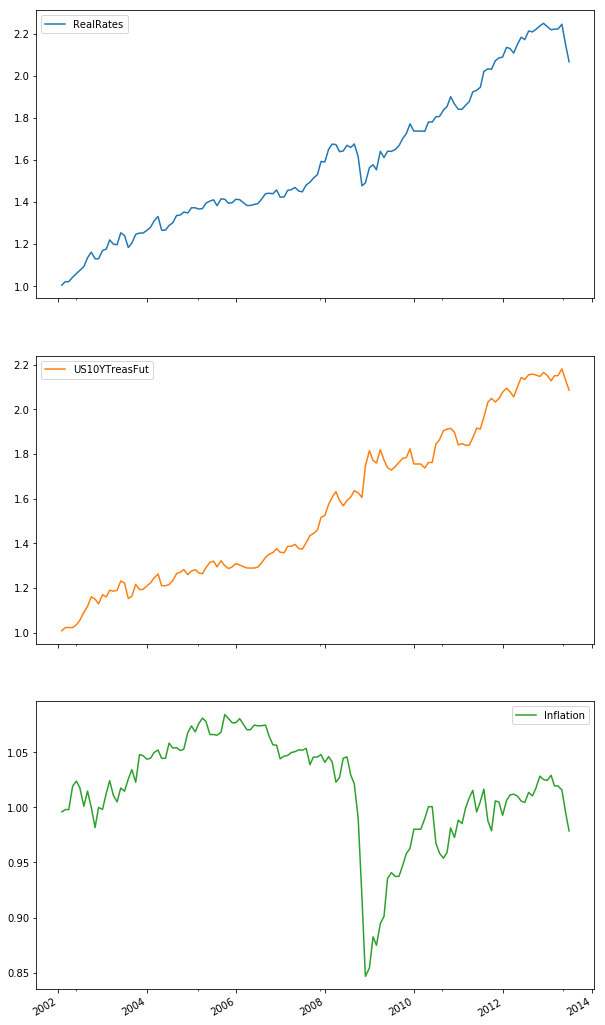

In [11]:
(factorRetDf[newFactors]+1).cumprod(axis=0).dropna(axis=0).plot(subplots=True, figsize=(10,20))